# IBM Applied Data Science Capstone Project

### Segmenting and Clustering Neighborhoods in Toronto

### In this notebook, we will retrieve, clean and analyze data about postal codes of Canada in the area around Toronto:

#### https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

---

## Task 1: Data Retrieval

In [1]:
!pip install lxml
import pandas as pd

  Using cached lxml-4.6.2-cp39-cp39-macosx_10_9_x86_64.whl (4.6 MB)


### We can download the data directly from the Wikipedia page, using the `read_html()` function provided by *pandas*

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Some Boroughs have a __'Not Assigned'__ value, so we want to drop the corresponding rows. We first find the indexes of those rows and get a new dataframe with the cleaned data.

In [3]:
idx = (df['Borough'] == 'Not assigned')
df_cleaned = df[~idx].reset_index(drop=True)
df_cleaned.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Finally, we can check the shape of the cleaned dataframe.

In [4]:
print(f'The dataframe now has {df_cleaned.shape[0]} rows and {df_cleaned.shape[1]} columns')

The dataframe now has 103 rows and 3 columns


---

## Task 2: Acquiring Geo Data

### For this task, we will use the *geocoder* package to acquire the latitude and longitude coordinates corresponding to the different postal codes in the area of Toronto, CA.

In [5]:
!pip install pgeocode
import pgeocode

  Using cached pgeocode-0.3.0-py3-none-any.whl (8.5 kB)


### First we will create an empty dataframe to collect the retrieved location data. Next, we can populate the rows of the dataframe one by one.

In [6]:
toronto_locations = pd.DataFrame(columns=['Postal Code', 'Latitude', 'Longitude'])
geolocator = pgeocode.Nominatim('ca')
for postal_code in df_cleaned['Postal Code'].values:
    print('Retrieving for postal code', postal_code)
    result = geolocator.query_postal_code(postal_code)
    lat = result['latitude']
    lng = result['longitude']
    print(f'Latitude: {lat}\nLongitude: {lng}')
    print('************************************')
    toronto_locations = toronto_locations.append({'Postal Code': postal_code,
                                                  'Latitude': lat,
                                                  'Longitude': lng}, ignore_index=True)

Retrieving for postal code M3A
Latitude: 43.7545
Longitude: -79.33
************************************
Retrieving for postal code M4A
Latitude: 43.7276
Longitude: -79.3148
************************************
Retrieving for postal code M5A
Latitude: 43.6555
Longitude: -79.3626
************************************
Retrieving for postal code M6A
Latitude: 43.7223
Longitude: -79.4504
************************************
Retrieving for postal code M7A
Latitude: 43.6641
Longitude: -79.3889
************************************
Retrieving for postal code M9A
Latitude: 43.6662
Longitude: -79.5282
************************************
Retrieving for postal code M1B
Latitude: 43.8113
Longitude: -79.193
************************************
Retrieving for postal code M3B
Latitude: 43.745
Longitude: -79.359
************************************
Retrieving for postal code M4B
Latitude: 43.7063
Longitude: -79.3094
************************************
Retrieving for postal code M5B
Latitude: 43.6572
Lo

Now that we have all the geodata for the postal codes, we can join the two dataframes that we created so far. We can also drop the row(s) for which we couldn't retrieve the location data.

In [7]:
toronto = df_cleaned.merge(toronto_locations, how='inner', on='Postal Code')
toronto.dropna(inplace=True)
toronto.reset_index(inplace=True, drop=True)
toronto.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


---

## Task 3: Exploration, Clustering and Visualization of the Neighborhoods

### For this task, we wil leverage the capabilities of the Foursquare API in order to retrieve information on the most popular venues in each of the neighborhoods in the Toronto area. The general idea is to look for the 10 most popular venue types in each zone and to then segment the neighborhoods into different clusters based on this information.

### We can start by visualizing the position of all zones on a map using the Python library *Folium*

In [8]:
!pip install folium
import folium

  Using cached folium-0.12.1-py2.py3-none-any.whl (94 kB)
  Using cached branca-0.4.2-py3-none-any.whl (24 kB)


In [9]:
coords = (toronto['Latitude'].mean(), toronto['Longitude'].mean())

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=coords, zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood, postal_code in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'],
                                                        toronto['Neighborhood'], toronto['Postal Code']):
    label = f'{neighborhood}, {borough}, {postal_code}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The map shows us the location of the different neighborhoods in the Toronto area. Now let's start using the Foursquare API to explore the surrounding venues.

To use this API, we need the access credentials.

In [10]:
# To run the rest of the code, please replace here your Foursquare credentials
CLIENT_ID = '****' # your Foursquare ID
CLIENT_SECRET = '****' # your Foursquare Secret
ACCESS_TOKEN = '****' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Next, we want to define a function to retrieve venues' information from the Foursquare API and collect the results in a new dataframe. This new table will contain information on each venue and on each corresponding neighborhood.

In [11]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT,
        )

        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]

        # return only relevant information for each nearby venue
        venues_list.append(
            [
                (
                    name,
                    lat,
                    lng,
                    v["venue"]["name"],
                    v["venue"]["location"]["lat"],
                    v["venue"]["location"]["lng"],
                    v["venue"]["categories"][0]["name"],
                )
                for v in results
            ]
        )

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list]
    )
    nearby_venues.columns = [
        "Neighborhood",
        "Neighborhood Latitude",
        "Neighborhood Longitude",
        "Venue",
        "Venue Latitude",
        "Venue Longitude",
        "Venue Category",
    ]

    return nearby_venues

In [12]:
toronto_venues = getNearbyVenues(toronto['Neighborhood'],
                                 toronto['Latitude'],
                                 toronto['Longitude'],
                                 radius = 750)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

### Now that we can check how many venues were retrieved in each neighborhood.

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,35,35,35,35,35,35
"Alderwood, Long Branch",14,14,14,14,14,14
"Bathurst Manor, Wilson Heights, Downsview North",38,38,38,38,38,38
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",51,51,51,51,51,51
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",9,9,9,9,9,9
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",47,47,47,47,47,47


### As we can see, there are several neighborhoods with just a few venues retrieved. Since we would like to find the 10 most common venues in each neighborhood, we remove venues from all the areas with very few venues.

In [40]:
toronto_venues_cleaned = toronto_venues.groupby('Neighborhood').filter(lambda x: len(x) > 25)
toronto_venues_cleaned.reset_index(drop=True, inplace=True)
toronto_venues_cleaned.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.6555,-79.3626,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.6555,-79.3626,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.6555,-79.3626,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.6555,-79.3626,Dominion Pub and Kitchen,43.656919,-79.358967,Pub
4,"Regent Park, Harbourfront",43.6555,-79.3626,Souvlaki Express,43.655584,-79.364438,Greek Restaurant


In [41]:
print(f"There are {toronto_venues_cleaned.groupby('Neighborhood').count().shape[0]} neighborhoods left for which enough venues were found")
print(f"There are {len(toronto_venues_cleaned['Venue Category'].unique())} uniques categories.")

There are 55 neighborhoods left for which enough venues were found
There are 326 uniques categories.


### WIth the data that we have now, we can start to analyze each neighborhood.
#### We can use the one-hot encoding method to check the frequency of individual venue categories in each area.

In [42]:
toronto_onehot = pd.get_dummies(toronto_venues_cleaned[['Venue Category']], prefix="", prefix_sep="")
indx = toronto_onehot[toronto_onehot['Neighborhood'] == 1].index
indx

Int64Index([366, 804, 1106, 1720, 1914, 2017, 3268, 3456], dtype='int64')

In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_cleaned[['Venue Category']], prefix="", prefix_sep="")

# some venues had as category 'Neighborhood', which was causing problems, so I removed it presented only for 8 venues
indx = toronto_onehot[toronto_onehot['Neighborhood'] == 1].index
toronto_onehot.drop(index=indx, inplace=True)
toronto_onehot.drop(columns='Neighborhood', inplace=True)
fixed_columns = list(toronto_onehot.columns.values)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_cleaned['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(3753, 326)

In [44]:
toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Theater,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Socc

### We can compare the frequency of venues in each neighborhood and for each category

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(f"There are {toronto_grouped.shape[1]} unique venue categories in {toronto_grouped.shape[0]} neighborhoods")
toronto_grouped.head()

There are 326 unique venue categories in 55 neighborhoods


,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Theater,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Socc

### We can transform the data again in order to get another dataframe collecting the 10 most common venues in each neighborhood

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_mostcommon = pd.DataFrame(columns=columns)
toronto_mostcommon['Neighborhood'] = toronto_grouped['Neighborhood']

for i in range(toronto_grouped.shape[0]):
    toronto_mostcommon.iloc[i, 1:] = return_most_common_venues(toronto_grouped.iloc[i, :], num_top_venues)

toronto_mostcommon.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Pharmacy,Malay Restaurant,Motorcycle Shop,Badminton Court,Clothing Store,Bakery,Sushi Restaurant,Supermarket
1,"Bathurst Manor, Wilson Heights, Downsview North",Spa,Pizza Place,Pharmacy,Coffee Shop,Ice Cream Shop,Mobile Phone Shop,Shopping Mall,Sushi Restaurant,Frozen Yogurt Shop,Supermarket
2,"Bedford Park, Lawrence Manor East",Spa,Italian Restaurant,Coffee Shop,Business Service,Hobby Shop,Pizza Place,Mobile Phone Shop,Massage Studio,Sandwich Place,Pharmacy
3,Berczy Park,Coffee Shop,Café,Japanese Restaurant,Restaurant,Beer Bar,Bakery,Hotel,Seafood Restaurant,Cocktail Bar,Gym
4,"Brockton, Parkdale Village, Exhibition Place",Café,Restaurant,Bar,Coffee Shop,Tibetan Restaurant,Bakery,Sandwich Place,Gift Shop,Arts & Crafts Store,Supermarket


### We want to use the KMeans algorithm to divide the neighborhoods in clusters.
#### We have to choose a number of clusters that the algorithm will divide the dataset in. The elbow method helps us with this choice. First we will process the data using an increasing number of centroids and calculate some accuracy metrics, namely the inertia and distortion.

In [48]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

toronto_grouped_clustering = toronto_grouped.drop("Neighborhood", 1)
inertias = []
distortions = []

for kclusters in range(1, 10):

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(
        toronto_grouped_clustering
    )

    inertias.append(kmeans.inertia_)
    distortions.append(
        sum(np.min(cdist(toronto_grouped_clustering, kmeans.cluster_centers_, "euclidean"), axis=1))
        / toronto_grouped_clustering.shape[0]
    )

#### Now we can plot the score of each model versus the number of clusters. We would expect to observe a decreasing score with more clusters, but at some point the gain in accuracy with incresing clusters should become very small

<function matplotlib.pyplot.show(close=None, block=None)>

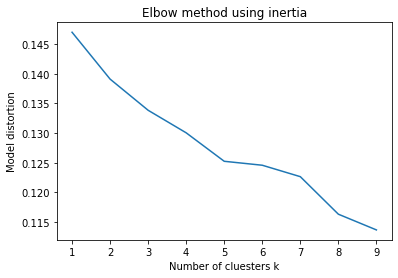

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(1,10), distortions)
plt.xlabel('Number of cluesters k')
plt.ylabel('Model distortion')
plt.title('Elbow method using inertia')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

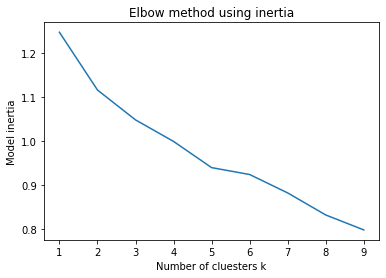

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(1,10), inertias)
plt.xlabel('Number of cluesters k')
plt.ylabel('Model inertia')
plt.title('Elbow method using inertia')
plt.show

#### Both plots for inertia and distortion do not clearly show an elbow point as we would otherwise have expected. From this we can conclude that our dataset does not naturally present a strong agglomeration of data in well defined clusters. Nevertheles, we can choose a number of centroids equal to 5 to continue with our analysis and observe which different characteristics the clusters expose

In [51]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

### We can add a column containing the cluster label for each Neighborhood and then use this information to assign different colors to their corresponding markers in the map of Toronto below

In [52]:
# add clustering labels
toronto_mostcommon.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_mostcommon with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_mostcommon.set_index('Neighborhood'), how='inner', on='Neighborhood').reset_index(drop=True)

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,0,Coffee Shop,Restaurant,Park,Café,Italian Restaurant,Pub,Bakery,Thai Restaurant,Theater,Furniture / Home Store
1,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,3,Clothing Store,Coffee Shop,Restaurant,Women's Store,Fast Food Restaurant,American Restaurant,Dessert Shop,Furniture / Home Store,Sandwich Place,Toy / Game Store
2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,4,Coffee Shop,Park,Sushi Restaurant,Café,Middle Eastern Restaurant,Yoga Studio,Italian Restaurant,Cosmetics Shop,Dessert Shop,Diner
3,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,0,Coffee Shop,Middle Eastern Restaurant,Clothing Store,Japanese Restaurant,Hotel,Gastropub,Cosmetics Shop,Diner,Restaurant,Café
4,M6B,North York,Glencairn,43.7081,-79.4479,1,Pizza Place,Grocery Store,Ice Cream Shop,Spa,Italian Restaurant,Bakery,Mediterranean Restaurant,Fish Market,Fast Food Restaurant,Bookstore


In [53]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# create map
map_clusters = folium.Map(location=coords, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### The map reveals 3 large clusters containing most of the neighborhoods and two smaller clusters containing 1 and 3 locations respectively.

### Cluster 0 (RED)
#### The neighborhoods belonging to this cluster are located all close to each other in the downtown area of the city, close to the port and to the airport.
#### The most common venue type is clearly cofee shops, cafès and restaurants of different types and culinary traditions. We also see hotels, gyms and some stores.
#### The position and variety of venue types hints to this being a turistic and business area, providing quick stops for quickply passing by visitors or workers.

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Restaurant,Park,Café,Italian Restaurant,Pub,Bakery,Thai Restaurant,Theater,Furniture / Home Store
3,Downtown Toronto,0,Coffee Shop,Middle Eastern Restaurant,Clothing Store,Japanese Restaurant,Hotel,Gastropub,Cosmetics Shop,Diner,Restaurant,Café
6,Downtown Toronto,0,Restaurant,Coffee Shop,Café,Italian Restaurant,Hotel,Seafood Restaurant,Bakery,Gastropub,Gym,Cosmetics Shop
8,Downtown Toronto,0,Coffee Shop,Café,Japanese Restaurant,Restaurant,Beer Bar,Bakery,Hotel,Seafood Restaurant,Cocktail Bar,Gym
10,Downtown Toronto,0,Coffee Shop,Café,Cosmetics Shop,Sushi Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Gym / Fitness Center,Clothing Store,Tea Room
14,Downtown Toronto,0,Coffee Shop,Café,Hotel,Restaurant,Gym,American Restaurant,Japanese Restaurant,Steakhouse,Theater,Deli / Bodega
18,West Toronto,0,Bar,Coffee Shop,Men's Store,Bakery,Café,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Cocktail Bar,Italian Restaurant
25,Downtown Toronto,0,Café,Coffee Shop,Restaurant,Hotel,Italian Restaurant,Gym,Japanese Restaurant,Steakhouse,Gastropub,Bakery
28,Downtown Toronto,0,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Steakhouse,American Restaurant,Theater,Gym,Italian Restaurant
41,Downtown Toronto,0,Coffee Shop,Café,Sandwich Place,Gym,Restaurant,Pub,Italian Restaurant,Bar,Bakery,Bookstore


### Cluster 1 (VIOLET)
#### Cluster 1 encompasses residential neighborhoods located mostly towards the outskirts of the city and away from the coast. The most common venues are restaurant and bars/coffee shops, but we also see an abundance of grocery stores, convenience storesm shopping malls and other retail businesses.

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,North York,1,Pizza Place,Grocery Store,Ice Cream Shop,Spa,Italian Restaurant,Bakery,Mediterranean Restaurant,Fish Market,Fast Food Restaurant,Bookstore
5,East York,1,Pizza Place,Smoke Shop,Electronics Store,Coffee Shop,Butcher,Skating Rink,Discount Store,Gas Station,Music Store,Bank
7,Scarborough,1,Pizza Place,Electronics Store,Pharmacy,Fast Food Restaurant,Breakfast Spot,Bank,Restaurant,Coffee Shop,Medical Center,Spa
9,East York,1,Furniture / Home Store,Insurance Office,Sporting Goods Shop,Electronics Store,Sandwich Place,Sports Bar,Bank,Rental Car Location,Department Store,Pet Store
12,North York,1,Spa,Pizza Place,Pharmacy,Coffee Shop,Ice Cream Shop,Mobile Phone Shop,Shopping Mall,Sushi Restaurant,Frozen Yogurt Shop,Supermarket
13,East York,1,Indian Restaurant,Mobile Phone Shop,Afghan Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Park,Turkish Restaurant,Yoga Studio,Middle Eastern Restaurant
19,Scarborough,1,Pharmacy,Discount Store,Coffee Shop,Convenience Store,Pizza Place,Chinese Restaurant,Rental Car Location,Grocery Store,Bus Line,Metro Station
20,North York,1,Coffee Shop,Grocery Store,Hotel,Mobile Phone Shop,Vietnamese Restaurant,Shopping Mall,Fast Food Restaurant,Pharmacy,Discount Store,Pizza Place
21,North York,1,Coffee Shop,Grocery Store,Hotel,Mobile Phone Shop,Vietnamese Restaurant,Shopping Mall,Fast Food Restaurant,Pharmacy,Discount Store,Pizza Place
22,North York,1,Coffee Shop,Grocery Store,Hotel,Mobile Phone Shop,Vietnamese Restaurant,Shopping Mall,Fast Food Restaurant,Pharmacy,Discount Store,Pizza Place


### Cluster 2 (BLUE)
#### This cluster hosts only a single neighborhood located in Downtown Toronto. By looking at the distribution of most common venues, it does not stand out compared to Cluster 1 and could possibly be merged with it. However, we see the presence of Korean, Mexican and Indian restaurants as well as Karaoke bars. It is possible then that this neighborhoods has a culturally different face compared to the areas in Cluster 1 and that the model picked up on this subtle difference.

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Downtown Toronto,2,Korean Restaurant,Café,Grocery Store,Coffee Shop,Mexican Restaurant,Pizza Place,Karaoke Bar,Sandwich Place,Indian Restaurant,Pub


### Cluster 3 (GREEN)
#### Here we see Clothing stores to be the most abundant type of venue, while the remaining common venues are other retail stores, dining places or in general locations where is possible to grab a bite of food. The 3 neighborhoods assigne to this cluster are located relatively far away from each, compared to the density of locations available. We can interpret them as neighborhoods that provide shopping and dining solutions to the residential areas nearby.

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,3,Clothing Store,Coffee Shop,Restaurant,Women's Store,Fast Food Restaurant,American Restaurant,Dessert Shop,Furniture / Home Store,Sandwich Place,Toy / Game Store
16,North York,3,Clothing Store,Shoe Store,Cosmetics Shop,Coffee Shop,Fast Food Restaurant,Women's Store,Sporting Goods Shop,Restaurant,Electronics Store,Rental Car Location
56,East Toronto,3,Restaurant,Clothing Store,Gym / Fitness Center,Mobile Phone Shop,Jewelry Store,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Sporting Goods Shop,Deli / Bodega


### Cluster 4 (ORANGE)
#### The remaninig cluster groups together neighborhoods with a majority of restaurants/dining places, cafès, bars and parks. At first glance, it could look similar to cluster 1, also considering that a significant fraction of ORANGE locations are surrounding the locations of Cluster 1. However, a closer inspection reveals that the abundance of hotels present in the RED neighborhoods is absent here. Moreover, we can also observe a wider variety of culinary traditions offered by areas in this cluster, with a higher ratio of fast food-like venues.

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,4,Coffee Shop,Park,Sushi Restaurant,Café,Middle Eastern Restaurant,Yoga Studio,Italian Restaurant,Cosmetics Shop,Dessert Shop,Diner
15,West Toronto,4,Coffee Shop,Bar,Bakery,Diner,Mexican Restaurant,Portuguese Restaurant,Cocktail Bar,Café,Park,Convenience Store
17,North York,4,Coffee Shop,Pizza Place,Spa,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Market,Massage Studio,Falafel Restaurant,Modern European Restaurant
24,East Toronto,4,Greek Restaurant,Coffee Shop,Café,Ice Cream Shop,Pub,Pizza Place,Sushi Restaurant,Bank,Fast Food Restaurant,Italian Restaurant
26,West Toronto,4,Café,Restaurant,Bar,Coffee Shop,Tibetan Restaurant,Bakery,Sandwich Place,Gift Shop,Arts & Crafts Store,Supermarket
27,East Toronto,4,Indian Restaurant,Restaurant,Park,Fast Food Restaurant,Pizza Place,Brewery,Gym,Grocery Store,Coffee Shop,Sandwich Place
29,North York,4,Middle Eastern Restaurant,Café,Korean Restaurant,Business Service,Pizza Place,Mobile Phone Shop,Sake Bar,Sandwich Place,Coffee Shop,Dessert Shop
30,East Toronto,4,Coffee Shop,American Restaurant,Gastropub,Bar,Brewery,Bakery,Café,Gym,Sandwich Place,Middle Eastern Restaurant
31,North York,4,Spa,Italian Restaurant,Coffee Shop,Business Service,Hobby Shop,Pizza Place,Mobile Phone Shop,Massage Studio,Sandwich Place,Pharmacy
32,North York,4,Coffee Shop,Korean Restaurant,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Grocery Store,Bank,Restaurant


## Conclusion
#### To summarize, we collected geographical information on the different neighborhoods in the Toronto urban area. We used this to request to the Foursquare API the information about venues belongin to every neighborhood within a certain radius from the center coordinates found before. By analyzing the venue types found for each area, we could provide a subdivision in clusters showcasing the different main features of each group.
#### We had to choose the number of clusters to divide the dataset in and we tried the elbow method using as accuracy score the inertia and distortion indicators. Both of them didn't reveal a clear better option for the number of centroids to find to divide the data. We decided to use 5, but during our analysis we found two clusters with only few members that could possibly be incorporated in other clusters. On the other hand, the most commond venues found in these small clusters, showed some variations and some differences in identity compared to the rest, so we can also consider this as the result of our model picking up on some more subtle differences.
#### In conclusion, our analysis revealed how the distribution of most common venues changes location by location and could be used as a starting point for a new business that wants to open a store/location in the city.